In [122]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os.path
import psycopg2

import configparser

In [106]:
# Path to the sql script used for getting images and details from database.
SELECT_IMAGE_SCRIPT_PATH = "database/select_aircraft_images.sql"

# Used as a performance argument.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Batch size for data set to process.
BATCH_SIZE = 32

# The file used for caching the dataset.
DATASET_CACHE_FILE = "dataset_cache"

In [107]:
class DBConfig:
    def __init__(self, filename, host, port, db_name, user, pwd):
        self.filename = filename
        self.host = host
        self.port = port
        self.db_name = db_name
        self.user = user
        self.pwd = pwd

In [108]:
def load_config(filename = 'database.ini', section = 'aircraft_postgres_db'):
    parser = configparser.ConfigParser()
    parser.read(filename)
    cfg = parser[section]
    return DBConfig(filename, cfg['Host'], int(cfg['Port']), cfg['Db_name'], cfg['User'], cfg['Pass'])

In [109]:
def load_sql(filename):
    with open(filename, "r") as sql_script_file:
        return sql_script_file.read()

In [131]:
def ready_image(image_details):
    path = image_details[0]
    variant_name = image_details[1]
    
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [128, 128])
    return img, variant_name

In [111]:
def prepare_image_dataset(image_paths_dataset):
    ds = image_paths_dataset.map(ready_image, num_parallel_calls=AUTOTUNE)
    
    ds = ds.cache(DATASET_CACHE_FILE)
    
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds
    

In [112]:
def train_on_images(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths);
    for (path, variant_name) in image_paths:
        img = read_parse_image(path)

In [127]:
# Taken from https://www.tensorflow.org/tutorials/load_data/images (09/06/2020)
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n].title())
      plt.axis('off')

In [113]:
db_cfg = load_config()

In [114]:
conn = psycopg2.connect(dbname=db_cfg.db_name, user=db_cfg.user, password=db_cfg.pwd, host=db_cfg.host, port=db_cfg.port)

In [115]:
cur = conn.cursor()
cur.execute('SELECT version()')
print("Connected to database, version: " + str(cur.fetchone()))

Connected to database, version: ('PostgreSQL 12.3, compiled by Visual C++ build 1914, 64-bit',)


In [116]:
select_image_sql = load_sql(SELECT_IMAGE_SCRIPT_PATH)

In [117]:
cur.execute(select_image_sql)

In [118]:
image_paths = cur.fetchall()

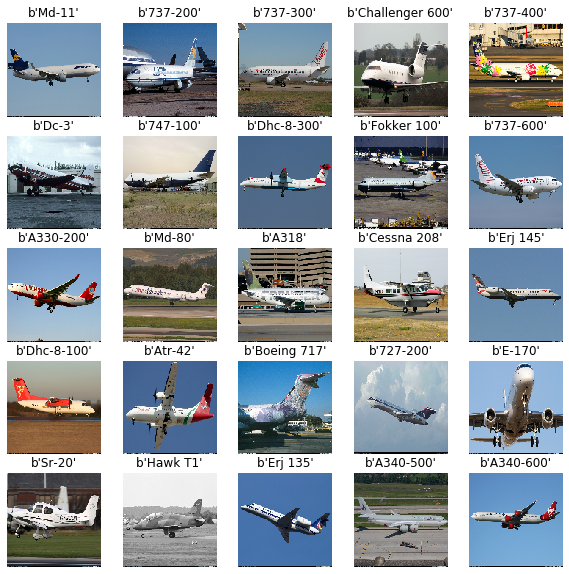

In [132]:
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

image_dataset = prepare_image_dataset(image_dataset)

img_batch, label_batch = next(iter(image_dataset))

show_batch(img_batch.numpy(), label_batch.numpy())


# Data is now loaded and ready, time to actually handle the model